# CBMC-Compatible Harness Generation System

This notebook implements the architecture outlined in the provided Mermaid diagram. The system uses LangGraph to orchestrate a workflow that analyzes source code for potential memory leaks and generates CBMC-compatible harnesses for verification.

In [1]:
# Import necessary libraries
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage, HumanMessage, SystemMessage, AIMessage
from langchain_core.tools import tool
from typing_extensions import Literal
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import json
import os
from typing import Dict, List, Any
import chromadb
from chromadb.utils import embedding_functions
import numpy as np

In [2]:
# Set up the LLM
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-7-sonnet-latest")

# Set up ChromaDB client
chroma_client = chromadb.Client()

# Create code collection with embedding function
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")
code_collection = chroma_client.create_collection(
    name="code_embeddings",
    embedding_function=sentence_transformer_ef,
    metadata={"hnsw:space": "cosine"}
)

# Create pattern collection for known memory leak patterns
pattern_collection = chroma_client.create_collection(
    name="pattern_embeddings",
    embedding_function=sentence_transformer_ef,
    metadata={"hnsw:space": "cosine"}
)

# Initialize pattern collection with known memory leak patterns
pattern_collection.add(
    ids=["pattern1", "pattern2", "pattern3"],
    documents=[
        "Allocation without corresponding deallocation (malloc without free)",
        "Nested malloc calls with potential for partial free",
        "Conditional free that might not execute in all paths"
    ],
    metadatas=[
        {
            "name": "malloc_without_free",
            "description": "Allocation without corresponding deallocation",
            "severity": "high",
            "verification_strategy": "Check all execution paths for memory deallocation"
        },
        {
            "name": "nested_malloc",
            "description": "Nested malloc calls with potential for partial free",
            "severity": "medium",
            "verification_strategy": "Ensure all allocations are freed in all execution paths"
        },
        {
            "name": "conditional_free",
            "description": "Conditional free that might not execute",
            "severity": "medium",
            "verification_strategy": "Verify all conditions that lead to memory release"
        }
    ]
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Define the State

We'll extend the basic MessagesState to include source code and other components required by our architecture.

In [3]:
# Define a custom state that extends MessagesState
class HarnessGenerationState(MessagesState):
    source_code: str = ""
    embeddings: Dict = {}
    vulnerable_functions: List[str] = []
    harnesses: Dict[str, str] = {}
    cbmc_results: Dict[str, str] = {}
    
    @property
    def is_done(self) -> bool:
        return len(self.vulnerable_functions) > 0 and all(
            func in self.cbmc_results for func in self.vulnerable_functions
        )

## Part 2: CBMC-Compatible Harness Generation System - Part 2: Core Tools


In [4]:
# Real code embedding tool using ChromaDB
@tool
def embed_code(code: str) -> Dict[str, Any]:
    """Embeds source code and stores it in the ChromaDB embedding database.
    
    Args:
        code: The source code to embed
    
    Returns:
        A dictionary of embedded code representations
    """
    # Parse the code to extract functions
    functions = {}
    
    # Simple parser to extract function names and bodies
    import re
    func_pattern = r"(\w+)\s+([\w_]+)\s*\(([^)]*)\)\s*\{([^}]*)\}"
    matches = re.findall(func_pattern, code)
    
    # Clear existing collection
    code_collection.delete(where={})
    
    # Process each function
    function_ids = []
    function_texts = []
    function_metadatas = []
    
    for match in matches:
        return_type, func_name, params, body = match
        full_text = f"{return_type} {func_name}({params}) {{{body}}}"
        
        # Store function details in our return dictionary
        functions[func_name] = {
            "return_type": return_type,
            "params": params.strip(),
            "body": body.strip(),
            "full_text": full_text
        }
        
        # Check for malloc/free in the body to add to metadata
        has_malloc = "malloc(" in body
        has_free = "free(" in body
        
        # Prepare for ChromaDB
        function_ids.append(func_name)
        function_texts.append(full_text)
        function_metadatas.append({
            "name": func_name,
            "return_type": return_type,
            "params": params.strip(),
            "has_malloc": has_malloc,
            "has_free": has_free,
            "allocation_without_free": has_malloc and not has_free
        })
    
    # Add to ChromaDB
    if function_ids:
        code_collection.add(
            ids=function_ids,
            documents=function_texts,
            metadatas=function_metadatas
        )
    
    return {
        "functions": functions,
        "message": f"Successfully embedded {len(functions)} functions in ChromaDB"
    }

In [5]:
# Real pattern database tool using ChromaDB
@tool
def query_pattern_db(query: str) -> Dict[str, Any]:
    """Queries the ChromaDB pattern database for known memory leak patterns.
    
    Args:
        query: The query string or function to match against patterns
    
    Returns:
        A dictionary of matching patterns
    """
    # Query the pattern collection to find relevant patterns
    results = pattern_collection.query(
        query_texts=[query],
        n_results=3  # Get the top 3 matching patterns
    )
    
    # Also check via metadata if the function contains known indicators
    if "malloc(" in query and "free(" not in query:
        # Direct metadata match for malloc without free
        direct_match = "malloc_without_free"
    elif "if" in query and "free(" in query:
        # Potential conditional free
        direct_match = "conditional_free"
    elif query.count("malloc(") > 1:
        # Multiple malloc calls
        direct_match = "nested_malloc"
    else:
        direct_match = None
    
    # Process results
    matching_patterns = {}
    
    # Add patterns from semantic search
    for i, (pattern_id, metadata, distance) in enumerate(zip(
        results['ids'][0],
        results['metadatas'][0],
        results['distances'][0]
    )):
        # Only include if reasonably close in embedding space
        if distance < 0.3:
            matching_patterns[metadata['name']] = {
                "description": metadata["description"],
                "severity": metadata["severity"],
                "verification_strategy": metadata["verification_strategy"],
                "similarity_score": 1.0 - distance  # Convert to similarity
            }
    
    # Add direct match if found and not already included
    if direct_match and direct_match not in matching_patterns:
        # Find the metadata for this pattern
        for metadata in pattern_collection.get(ids=[f"pattern{['malloc_without_free', 'nested_malloc', 'conditional_free'].index(direct_match) + 1}"])['metadatas']:
            if metadata['name'] == direct_match:
                matching_patterns[direct_match] = {
                    "description": metadata["description"],
                    "severity": metadata["severity"],
                    "verification_strategy": metadata["verification_strategy"],
                    "similarity_score": 1.0  # Direct match gets perfect score
                }
                break
    
    return {
        "matching_patterns": matching_patterns,
        "message": f"Found {len(matching_patterns)} potential matching patterns via ChromaDB"
    }

In [6]:
# CBMC verification tool using actual CBMC with direct source code and enhanced verbosity
@tool
def run_cbmc(function_name: str, harness_code: str, source_code: str) -> Dict[str, Any]:
    """Runs real CBMC verification on the provided source code with the harness.
    
    Args:
        function_name: The name of the function being verified
        harness_code: The harness code to be verified by CBMC
        source_code: The original source code containing the function
    
    Returns:
        Results of the CBMC verification with detailed output
    """
    if not source_code:
        return {
            "function": function_name,
            "status": "ERROR",
            "message": "Source code not provided.",
            "suggestions": "Ensure source code is properly passed to the verification tool."
        }
    
    # Create temporary files for verification
    import tempfile
    import os
    import subprocess
    import re
    
    with tempfile.TemporaryDirectory() as temp_dir:
        # Create a detailed log file for the verification process
        log_file = os.path.join(temp_dir, "cbmc_verification.log")
        with open(log_file, "w") as log:
            log.write(f"=== CBMC Verification for function: {function_name} ===\n\n")
            
            # Write the original source code to a file
            source_file = os.path.join(temp_dir, "source.c")
            with open(source_file, "w") as f:
                f.write(source_code)
            log.write(f"Source code written to: {source_file}\n")
            
            # Write the harness code to a file
            harness_file = os.path.join(temp_dir, f"{function_name}_harness.c")
            with open(harness_file, "w") as f:
                f.write(harness_code)
            log.write(f"Harness code written to: {harness_file}\n")
            
            # Construct the CBMC command with verbose output
            cbmc_cmd = [
                "cbmc",
                source_file,
                harness_file,
                "--function", "main",  # Target the main function in the harness
                "--bounds-check",
                "--pointer-check",
                "--memory-leak-check",
                "--div-by-zero-check",
                "--signed-overflow-check",
                "--unsigned-overflow-check",
                "--pointer-overflow-check",
                "--conversion-check",
                "--trace",
                "--verbosity", "10",   # Increase verbosity for detailed output
                "--show-properties",   # Show all properties being checked
                "--show-loops",        # Show loop information
                "--xml-ui"             # Structured XML output for easier parsing
            ]
            
            log.write(f"CBMC command: {' '.join(cbmc_cmd)}\n\n")
            
            try:
                # Run CBMC and capture output
                log.write("Starting CBMC verification...\n")
                result = subprocess.run(
                    cbmc_cmd,
                    capture_output=True,
                    text=True,
                    timeout=60  # Increased timeout for more complex verifications
                )
                
                # Log the raw output
                log.write(f"CBMC exit code: {result.returncode}\n")
                log.write("--- CBMC STDOUT ---\n")
                log.write(result.stdout)
                log.write("\n--- CBMC STDERR ---\n")
                log.write(result.stderr)
                log.write("\n--------------------\n")
                
                # Parse the XML output for structured information
                cbmc_output = result.stdout
                cbmc_error = result.stderr
                exit_code = result.returncode
                
                # Look for specific patterns in the output
                memory_leak_patterns = [
                    r"dereference failure: forgotten memory",
                    r"memory leak detected",
                    r"dynamically allocated memory never freed"
                ]
                
                null_pointer_patterns = [
                    r"dereference failure: NULL pointer",
                    r"dereference failure: deallocated dynamic object",
                    r"dereference failure: pointer NULL"
                ]
                
                buffer_overflow_patterns = [
                    r"array bounds violated",
                    r"pointer outside object bounds",
                    r"buffer overflow detected"
                ]
                
                # Check for different types of issues
                memory_leak_detected = any(re.search(pattern, cbmc_output) for pattern in memory_leak_patterns)
                null_pointer_detected = any(re.search(pattern, cbmc_output) for pattern in null_pointer_patterns)
                buffer_overflow_detected = any(re.search(pattern, cbmc_output) for pattern in buffer_overflow_patterns)
                
                # Extract detailed trace information for memory leaks
                trace_info = ""
                if memory_leak_detected:
                    trace_match = re.search(r"Trace for (.+?):\n(.*?)(?:\n\n|\Z)", cbmc_output, re.DOTALL)
                    if trace_match:
                        trace_info = trace_match.group(2)
                        log.write(f"Extracted trace information:\n{trace_info}\n")
                
                # Determine status and generate detailed feedback
                if exit_code == 0:
                    status = "SUCCESS"
                    message = "VERIFICATION SUCCESSFUL: No memory leaks or safety issues detected."
                    suggestions = "The function appears to properly manage memory across all execution paths."
                    
                    # Check if verification was trivial (might indicate issues with the harness)
                    if "No VCC" in cbmc_output or "0 VCC" in cbmc_output:
                        message += " (Note: No verification conditions checked - harness may need improvement)"
                        suggestions += " Consider enhancing the harness to exercise more paths."
                
                elif memory_leak_detected:
                    status = "FAILED"
                    
                    # Extract specific details about the leak
                    leak_location = re.search(r"file (.*?) line (\d+) function (.*?):", cbmc_output)
                    if leak_location:
                        file_name, line_number, func_name = leak_location.groups()
                        message = f"VERIFICATION FAILED: Memory leak detected in function '{func_name}' at line {line_number}."
                    else:
                        message = "VERIFICATION FAILED: Memory leak detected."
                    
                    if trace_info:
                        message += f" Trace information shows leak occurs after sequence: {trace_info[:100]}..."
                    
                    suggestions = (
                        "Ensure all allocated memory is freed before function exit. "
                        "Check conditional paths that might bypass free() calls. "
                        "Consider using a cleanup pattern to ensure resources are released in all execution paths."
                    )
                
                elif null_pointer_detected:
                    status = "FAILED"
                    
                    # Extract specific details about the null pointer
                    null_ptr_location = re.search(r"file (.*?) line (\d+) function (.*?):", cbmc_output)
                    if null_ptr_location:
                        file_name, line_number, func_name = null_ptr_location.groups()
                        message = f"VERIFICATION FAILED: Null pointer dereference in function '{func_name}' at line {line_number}."
                    else:
                        message = "VERIFICATION FAILED: Null pointer dereference detected."
                    
                    suggestions = (
                        "Add explicit NULL checks before dereferencing pointers. "
                        "Verify all malloc/calloc return values are checked before use. "
                        "Consider defensive programming techniques to handle NULL values gracefully."
                    )
                
                elif buffer_overflow_detected:
                    status = "FAILED"
                    message = "VERIFICATION FAILED: Buffer overflow or array bounds violation detected."
                    suggestions = (
                        "Ensure all array accesses are within bounds. "
                        "Add explicit bounds checking before accessing arrays. "
                        "Consider using safer string manipulation functions."
                    )
                
                else:
                    status = "FAILED"
                    message = "VERIFICATION FAILED: Safety property violation detected."
                    
                    # Try to extract specific failure message for more informative feedback
                    property_failure = re.search(r"FAILURE\n(.*?)\n", cbmc_output)
                    if property_failure:
                        message += f" {property_failure.group(1)}"
                    
                    suggestions = (
                        "Review the detailed CBMC output for specific verification failures. "
                        "Check for arithmetic errors, uninitialized variables, or other safety issues."
                    )
                
                # Log the final determination
                log.write(f"\nFinal determination:\n")
                log.write(f"Status: {status}\n")
                log.write(f"Message: {message}\n")
                log.write(f"Suggestions: {suggestions}\n")
                
                # Read the log file for inclusion in the result
                with open(log_file, "r") as log_reader:
                    verification_log = log_reader.read()
                
                # Capture examples from the code to illustrate the issue
                code_examples = []
                if memory_leak_detected or null_pointer_detected or buffer_overflow_detected:
                    # Look for line numbers in the error messages
                    line_numbers = re.findall(r"line (\d+)", cbmc_output)
                    if line_numbers:
                        for line_num in line_numbers[:3]:  # Limit to first 3 line numbers
                            try:
                                line_num = int(line_num)
                                source_lines = source_code.splitlines()
                                if 0 < line_num <= len(source_lines):
                                    # Get the problematic line and some context
                                    start = max(0, line_num - 3)
                                    end = min(len(source_lines), line_num + 2)
                                    context = "\n".join(f"{i+1}: {line}" for i, line in enumerate(source_lines[start:end]))
                                    code_examples.append(f"Context around line {line_num}:\n{context}")
                            except (ValueError, IndexError):
                                pass
                
                # Return comprehensive verification results
                return {
                    "function": function_name,
                    "status": status,
                    "message": message,
                    "suggestions": suggestions,
                    "code_examples": code_examples,
                    "cbmc_output_excerpt": cbmc_output[:1000] if len(cbmc_output) > 1000 else cbmc_output,
                    "exit_code": exit_code,
                    "verification_log_excerpt": verification_log[:5000] if len(verification_log) > 5000 else verification_log
                }
            
            except subprocess.TimeoutExpired:
                log.write("\nCBMC verification timed out after 60 seconds.\n")
                
                return {
                    "function": function_name,
                    "status": "TIMEOUT",
                    "message": "CBMC verification timed out after 60 seconds.",
                    "suggestions": (
                        "Consider simplifying the harness or function. "
                        "The verification might be too complex for automated analysis. "
                        "Try breaking the verification into smaller parts or increase the timeout."
                    )
                }
            
            except Exception as e:
                log.write(f"\nError during CBMC verification: {str(e)}\n")
                
                # Try to determine if CBMC is installed
                cbmc_check = subprocess.run(["which", "cbmc"], capture_output=True, text=True)
                cbmc_installed = cbmc_check.returncode == 0
                
                # Generate appropriate error message based on the issue
                if not cbmc_installed:
                    message = "CBMC is not installed or not in the PATH."
                    suggestions = "Install CBMC tool before running verification."
                else:
                    message = f"Error running CBMC: {str(e)}"
                    suggestions = "Verify the code is valid C and CBMC is configured correctly."
                
                return {
                    "function": function_name,
                    "status": "ERROR",
                    "message": message,
                    "suggestions": suggestions,
                    "error_details": str(e)
                }

In [7]:
# Create a list of tools and bind them to the LLM
tools = [embed_code, query_pattern_db, run_cbmc]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

## Part 3: CBMC-Compatible Harness Generation System - Part 3: Node Functions (First Half)


In [8]:
# Node 1: Frontend - Initial processing of source code
def frontend_node(state: HarnessGenerationState):
    """Processes the source code and prepares it for embedding."""
    
    if not state.source_code:
        # Extract source code from the latest message if available
        for message in reversed(state["messages"]):
            if isinstance(message, HumanMessage) and "```" in message.content:
                # Extract code between triple backticks
                import re
                match = re.search(r'```(?:\w+)?\n(.+?)\n```', message.content, re.DOTALL)
                if match:
                    state.source_code = match.group(1)
                    break
    
    # If no source code found, ask the user
    if not state.source_code:
        return {
            "messages": [AIMessage(content="Please provide the source code you'd like to analyze for memory leaks.")]
        }
    
    # Proceed to the next step with the source code
    return {
        "messages": [AIMessage(content=f"Received source code ({len(state.source_code)} characters). Proceeding with code embedding and analysis.")],
        "source_code": state.source_code
    }

In [9]:
# Node 2: Code Embedding System
def code_embedding_node(state: HarnessGenerationState):
    """Embeds the source code and stores it in the database."""
    
    # Call the embedding tool
    result = embed_code(state.source_code)
    
    # Store the embeddings
    state.embeddings = result
    
    return {
        "messages": [AIMessage(content=f"Source code embedded successfully. Found {len(result['functions'])} functions.")],
        "embeddings": result
    }

In [10]:
# Node 3: Analyzer (LLM Agent)
def analyzer_node(state: HarnessGenerationState):
    """LLM-based analyzer that identifies potential memory leak vulnerabilities using ChromaDB."""
    
    # Query ChromaDB for functions with potential memory leak indicators
    # First, get all functions that have malloc but no free
    potential_leaks = code_collection.get(
        where={"has_malloc": True, "has_free": False}
    )
    
    # Also get functions with both malloc and free for further analysis
    functions_with_both = code_collection.get(
        where={"has_malloc": True, "has_free": True}
    )
    
    # Create a list of all function details to present to the LLM
    all_functions = {}
    
    # Add potential leaks first
    for i, func_id in enumerate(potential_leaks["ids"]):
        all_functions[func_id] = {
            "full_text": potential_leaks["documents"][i],
            "potential_leak": True
        }
    
    # Add other functions that use malloc
    for i, func_id in enumerate(functions_with_both["ids"]):
        if func_id not in all_functions:
            all_functions[func_id] = {
                "full_text": functions_with_both["documents"][i],
                "potential_leak": False
            }
    
    analyzer_prompt = f"""
    You are a specialized code analyzer focused on identifying potential memory leaks in C code.
    Analyze the following functions and identify those that might have memory leak vulnerabilities.
    Look for patterns like:
    1. Malloc without corresponding free
    2. Conditional frees that might not execute
    3. Error paths that don't properly clean up resources
    4. Nested allocations with incomplete cleanup
    
    Here are the functions to analyze, with preliminary analysis from our system:
    {json.dumps(all_functions, indent=2)}
    
    Some functions are already flagged with 'potential_leak: true' based on initial analysis.
    Please verify these and check other functions for more complex memory leak patterns.
    
    For each suspicious function, use the query_pattern_db tool to find matching memory leak patterns.
    
    Output a list of function names that might have memory leaks, with a brief explanation for each.
    """
    
    # Call the LLM with the analyzer prompt
    response = llm_with_tools.invoke(
        [
            SystemMessage(content=analyzer_prompt)
        ]
    )
    
    # Process the analyzer response to extract vulnerable functions
    # Check for tool calls to pattern_db in the response
    vulnerable_functions = []
    
    # If tool calls were made, process their results
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tool_call in response.tool_calls:
            if tool_call["name"] == "query_pattern_db":
                # Extract function name from the query if possible
                query = tool_call["args"]
                for func_name in all_functions.keys():
                    if func_name in str(query):
                        if func_name not in vulnerable_functions:
                            vulnerable_functions.append(func_name)
    
    # If no tool calls or vulnerable functions found, extract from content
    if not vulnerable_functions:
        for func_name in all_functions.keys():
            if func_name.lower() in response.content.lower():
                vulnerable_functions.append(func_name)
    
    # As a fallback, use our initial analysis
    if not vulnerable_functions:
        for func_name, func_info in all_functions.items():
            if func_info.get("potential_leak", False):
                vulnerable_functions.append(func_name)
    
    return {
        "messages": [AIMessage(content=f"Analysis complete. Identified {len(vulnerable_functions)} potentially vulnerable functions: {', '.join(vulnerable_functions)}")],
        "vulnerable_functions": vulnerable_functions
    }

In [11]:
# Node 4: Junction - Routes each vulnerable function to the generator
def junction_node(state: HarnessGenerationState):
    """Junction that creates processing tasks for each vulnerable function."""
    
    # Simply pass through the state - in a real implementation, this might
    # set up parallel processing or create a queue of functions to process
    return {
        "messages": [AIMessage(content="Preparing to generate harnesses for each vulnerable function.")]
    }

## Part 4: CBMC-Compatible Harness Generation System - Part 4: Node Functions (Second Half)


In [12]:
# Node 5: Generator (LLM Agent) - Generates CBMC harnesses
def generator_node(state: HarnessGenerationState):
    """Generates CBMC-compatible harnesses for the vulnerable functions using ChromaDB data."""
    
    harnesses = {}
    
    for func_name in state.vulnerable_functions:
        # Get function code from ChromaDB
        function_result = code_collection.get(
            ids=[func_name],
            include=["documents", "metadatas"]
        )
        
        if function_result["ids"]:
            func_code = function_result["documents"][0]
            func_metadata = function_result["metadatas"][0]
            
            # Query patterns for this function
            patterns_result = query_pattern_db(func_code)
            
            # Get parameter information
            return_type = func_metadata.get("return_type", "void")
            params = func_metadata.get("params", "")
            has_malloc = func_metadata.get("has_malloc", False)
            has_free = func_metadata.get("has_free", False)
            
            # Build the generator prompt with CBMC-specific instructions
            generator_prompt = f"""
            You are a specialized harness generator for CBMC verification.
            Create a CBMC-compatible harness for the following function that might have memory leaks:
            
            ```c
            {func_code}
            ```
            
            Function metadata:
            - Return type: {return_type}
            - Parameters: {params}
            - Contains malloc: {has_malloc}
            - Contains free: {has_free}
            
            Matching vulnerability patterns:
            {json.dumps(patterns_result['matching_patterns'], indent=2)}
            
            The harness should:
            1. Create realistic inputs for the function
            2. Set up appropriate CBMC assertions and assumptions (__CPROVER_assert, __CPROVER_assume)
            3. Properly call the function and check its behavior
            4. Include memory leak checks
            5. Follow CBMC's harness structure with a void main() function
            
            For memory leak detection, make sure to:
            - Track all allocated memory
            - Verify memory is properly freed for all execution paths
            - Use CBMC-specific features for verification
            
            Provide only the harness code without explanation.
            """
            
            # Generate the harness using the LLM
            response = llm.invoke([SystemMessage(content=generator_prompt)])
            
            # Extract the harness code (assuming it's between code blocks)
            import re
            harness_code = response.content
            match = re.search(r'```(?:c)?\n(.+?)\n```', harness_code, re.DOTALL)
            if match:
                harness_code = match.group(1)
            else:
                harness_code = harness_code  # Use the whole content if no code block is found
            
            harnesses[func_name] = harness_code
    
    return {
        "messages": [AIMessage(content=f"Generated harnesses for {len(harnesses)} functions.")],
        "harnesses": harnesses
    }

In [13]:
# Node 6: CBMC - Runs verification using the generated harnesses
def cbmc_node(state: HarnessGenerationState):
    """Runs CBMC verification on the generated harnesses."""
    
    cbmc_results = {}
    
    for func_name, harness_code in state.harnesses.items():
        # Run CBMC verification
        result = run_cbmc(func_name, harness_code)
        cbmc_results[func_name] = result
    
    # Format results for display
    results_summary = []
    for func_name, result in cbmc_results.items():
        status = result["status"]
        message = result["message"]
        suggestions = result["suggestions"]
        
        summary = f"Function: {func_name}\nStatus: {status}\nMessage: {message}"
        if suggestions:
            summary += f"\nSuggestions: {suggestions}"
        
        results_summary.append(summary)
    
    results_text = "\n\n".join(results_summary)
    
    return {
        "messages": [AIMessage(content=f"CBMC Verification Results:\n\n{results_text}")],
        "cbmc_results": cbmc_results
    }

In [14]:
# Node 7: Output/Frontend - Final results processing
def output_node(state: HarnessGenerationState):
    """Processes the verification results and prepares the output."""
    
    # Create a comprehensive summary of the entire process
    summary = [
        "# Memory Leak Verification Summary",
        "",
        f"Analyzed {len(state.embeddings.get('functions', {}))} functions.",
        f"Identified {len(state.vulnerable_functions)} potentially vulnerable functions.",
        f"Generated {len(state.harnesses)} verification harnesses.",
        f"Completed {len(state.cbmc_results)} CBMC verifications.",
        "",
        "## Detailed Results"
    ]
    
    for func_name in state.vulnerable_functions:
        if func_name in state.cbmc_results:
            result = state.cbmc_results[func_name]
            summary.append(f"\n### Function: {func_name}")
            summary.append(f"Status: {result['status']}")
            summary.append(f"Message: {result['message']}")
            if result["suggestions"]:
                summary.append(f"Suggestions: {result['suggestions']}")
            
            if func_name in state.harnesses:
                summary.append("\nGenerated Harness:")
                summary.append("```c")
                summary.append(state.harnesses[func_name])
                summary.append("```")
    
    # Create the final output message
    final_summary = "\n".join(summary)
    
    return {
        "messages": [AIMessage(content=final_summary)]
    }

In [15]:
# Conditional edge function for tool calls
def route_based_on_tool_use(state: HarnessGenerationState) -> Literal["tool_execution", "continue"]:
    """Route to tool execution if the last message contains tool calls."""
    messages = state["messages"]
    last_message = messages[-1]
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tool_execution"
    return "continue"

# Function to execute tool calls
def execute_tools(state: HarnessGenerationState):
    """Executes any tool calls in the last message."""
    messages = state["messages"]
    last_message = messages[-1]
    
    results = []
    for tool_call in last_message.tool_calls:
        tool = tools_by_name[tool_call["name"]]
        result = tool.invoke(tool_call["args"])
        results.append(ToolMessage(content=str(result), tool_call_id=tool_call["id"]))
    
    return {"messages": results}

## Part 5: CBMC-Compatible Harness Generation System - Part 5: Graph Assembly and Testing


In [28]:
from langgraph.graph import StateGraph, START, END
from typing import Dict, List, Any, Literal
import subprocess
import tempfile
import os
import json

# Define the state
class HarnessGenerationState(MessagesState):
    source_code: str = ""
    embeddings: Dict = {}
    vulnerable_functions: List[str] = []
    harnesses: Dict[str, str] = {}
    cbmc_results: Dict[str, Any] = {}
    refinement_attempts: Dict[str, int] = {}

# Node 1: Frontend - Initial processing of source code
def frontend_node(state):
    """Extracts source code from user messages."""
    # Extract source code from messages if not already available
    if not state.source_code:
        for message in reversed(state["messages"]):
            if isinstance(message, HumanMessage) and "```" in message.content:
                import re
                match = re.search(r'```(?:\w+)?\\n(.+?)\\n```', message.content, re.DOTALL)
                if match:
                    state.source_code = match.group(1)
                    break
    
    return {
        "messages": [AIMessage(content=f"Received source code ({len(state.source_code)} characters). Proceeding with code embedding.")],
        "source_code": state.source_code
    }

# Node 2: Code Embedding System - Stores code in database
def code_embedding_node(state):
    """Embeds and stores code in the database."""
    # Call embedding tool to store in CodeDB
    result = embed_code(state.source_code)
    state.embeddings = result
    
    return {
        "messages": [AIMessage(content=f"Source code embedded successfully. Found {len(result['functions'])} functions.")],
        "embeddings": result
    }

# Node 3: Analyzer - Identifies vulnerable functions
def analyzer_node(state):
    """Analyzes code from CodeDB to identify potentially vulnerable functions."""
    # Get functions from code database with potential memory leak patterns
    potential_leaks = code_collection.get(where={"has_malloc": True, "has_free": False})
    vulnerable_functions = []
    
    # Process database results
    for i, func_id in enumerate(potential_leaks["ids"]):
        vulnerable_functions.append(func_id)
        
    # Also check functions with both malloc and free for conditional paths
    functions_with_both = code_collection.get(where={"has_malloc": True, "has_free": True})
    for i, func_id in enumerate(functions_with_both["ids"]):
        # Query patterns to check for conditional free issues
        func_code = functions_with_both["documents"][i]
        patterns_result = query_pattern_db(func_code)
        if "conditional_free" in patterns_result.get("matching_patterns", {}):
            vulnerable_functions.append(func_id)
    
    return {
        "messages": [AIMessage(content=f"Analysis complete. Identified {len(vulnerable_functions)} potentially vulnerable functions: {', '.join(vulnerable_functions)}")],
        "vulnerable_functions": vulnerable_functions
    }

# Node 4: Junction - Routes each vulnerable function
def junction_node(state):
    """Creates a processing task for each vulnerable function."""
    return {
        "messages": [AIMessage(content=f"Preparing to generate harnesses for {len(state.vulnerable_functions)} functions.")],
    }

# Node 5: Generator - Creates harnesses
def generator_node(state):
    """Generates CBMC-compatible harnesses for the vulnerable functions."""
    harnesses = {}
    
    for func_name in state.vulnerable_functions:
        # Skip functions we already have harnesses for (unless being refined)
        if func_name in state.harnesses and func_name not in state.get("refining_functions", []):
            harnesses[func_name] = state.harnesses[func_name]
            continue
        
        # Get function code from CodeDB
        function_result = code_collection.get(ids=[func_name], include=["documents", "metadatas"])
        
        if function_result["ids"]:
            func_code = function_result["documents"][0]
            func_metadata = function_result["metadatas"][0]
            
            # Get pattern information from PatternDB
            patterns_result = query_pattern_db(func_code)
            
            # Build generator prompt
            generator_prompt = f"""
            You are a specialized harness generator for CBMC verification.
            Create a CBMC-compatible harness for the following function that might have memory leaks:
            
            ```c
            {func_code}
            ```
            
            Function metadata:
            - Return type: {func_metadata.get("return_type", "void")}
            - Parameters: {func_metadata.get("params", "")}
            - Contains malloc: {func_metadata.get("has_malloc", False)}
            - Contains free: {func_metadata.get("has_free", False)}
            
            Matching vulnerability patterns:
            {json.dumps(patterns_result.get('matching_patterns', {}), indent=2)}
            
            The harness should:
            1. Create realistic inputs for the function
            2. Set up appropriate CBMC assertions and assumptions (__CPROVER_assert, __CPROVER_assume)
            3. Properly call the function and check its behavior
            4. Include memory leak checks
            5. Follow CBMC's harness structure with a void main() function
            
            Provide only the harness code without explanation.
            """
            
            # Generate the harness
            response = llm.invoke([SystemMessage(content=generator_prompt)])
            
            # Extract the harness code
            import re
            harness_code = response.content
            match = re.search(r'```(?:c)?\\n(.+?)\\n```', harness_code, re.DOTALL)
            if match:
                harness_code = match.group(1)
            
            harnesses[func_name] = harness_code
    
    # Clear the refining functions list
    if "refining_functions" in state:
        del state["refining_functions"]
    
    return {
        "messages": [AIMessage(content=f"Generated harnesses for {len(harnesses)} functions.")],
        "harnesses": harnesses
    }

# Node 6: CBMC - Executes CBMC tool for verification
def cbmc_node(state):
    """Executes CBMC verification on the harnesses."""
    results = {}
    
    for func_name, harness_code in state.harnesses.items():
        # Skip functions we already have results for (unless being refined)
        if func_name in state.cbmc_results and func_name not in state.get("refining_functions", []):
            results[func_name] = state.cbmc_results[func_name]
            continue
            
        # Execute CBMC on the harness
        with tempfile.TemporaryDirectory() as temp_dir:
            # Write source code to file
            source_file = os.path.join(temp_dir, "source.c")
            with open(source_file, "w") as f:
                f.write(state.source_code)
                
            # Write harness to file
            harness_file = os.path.join(temp_dir, f"{func_name}_harness.c")
            with open(harness_file, "w") as f:
                f.write(harness_code)
                
            # Run CBMC
            cbmc_cmd = [
                "cbmc",
                source_file,
                harness_file,
                "--function", "main",
                "--bounds-check",
                "--pointer-check",
                "--memory-leak-check",
                "--div-by-zero-check"
            ]
            
            try:
                # Execute CBMC and capture output
                result = subprocess.run(
                    cbmc_cmd,
                    capture_output=True,
                    text=True,
                    timeout=60
                )
                
                # Process results
                status = "SUCCESS" if result.returncode == 0 else "FAILED"
                message = "VERIFICATION SUCCESSFUL: No memory leaks detected."
                suggestions = ""
                
                if result.returncode != 0:
                    if "memory leak detected" in result.stdout:
                        message = "VERIFICATION FAILED: Memory leak detected."
                        suggestions = "Ensure all allocated memory is freed in all execution paths."
                    elif "NULL pointer dereference" in result.stdout:
                        message = "VERIFICATION FAILED: Null pointer dereference detected."
                        suggestions = "Add null pointer checks before dereferencing."
                    else:
                        message = f"VERIFICATION FAILED: {result.stdout[:200]}..."
                
                results[func_name] = {
                    "function": func_name,
                    "status": status,
                    "message": message,
                    "suggestions": suggestions,
                    "stdout": result.stdout[:1000] if len(result.stdout) > 1000 else result.stdout,
                    "returncode": result.returncode
                }
                
            except Exception as e:
                results[func_name] = {
                    "function": func_name,
                    "status": "ERROR",
                    "message": f"Error running CBMC: {str(e)}",
                    "suggestions": "Check if CBMC is installed correctly."
                }
    
    # Format summary for display
    summary_items = []
    for func_name, result in results.items():
        summary = f"Function: {func_name}\nStatus: {result['status']}\nMessage: {result['message']}"
        if result.get("suggestions"):
            summary += f"\nSuggestions: {result['suggestions']}"
        summary_items.append(summary)
    
    summary = "\n\n".join(summary_items)
    
    return {
        "messages": [AIMessage(content=f"CBMC Verification Results:\n\n{summary}")],
        "cbmc_results": results
    }

# Node 7: Output - Final results processing
def output_node(state):
    """Processes verification results and prepares final output."""
    # Create comprehensive summary
    summary = [
        "# Memory Leak Verification Summary",
        "",
        f"Analyzed {len(state.embeddings.get('functions', {}))} functions.",
        f"Identified {len(state.vulnerable_functions)} potentially vulnerable functions.",
        f"Generated {len(state.harnesses)} verification harnesses.",
        f"Completed {len(state.cbmc_results)} CBMC verifications.",
        "",
        "## Detailed Results"
    ]
    
    for func_name in state.vulnerable_functions:
        if func_name in state.cbmc_results:
            result = state.cbmc_results[func_name]
            summary.append(f"\n### Function: {func_name}")
            summary.append(f"Status: {result['status']}")
            summary.append(f"Message: {result['message']}")
            if result.get("suggestions"):
                summary.append(f"Suggestions: {result['suggestions']}")
            
            if func_name in state.harnesses:
                summary.append("\nGenerated Harness:")
                summary.append("```c")
                summary.append(state.harnesses[func_name])
                summary.append("```")
    
    final_summary = "\n".join(summary)
    
    return {
        "messages": [AIMessage(content=final_summary)]
    }

# Conditional routing function for CBMC refinement
def need_refinement(state: HarnessGenerationState) -> Literal["refine", "continue"]:
    """Determine if any harnesses need refinement based on CBMC results."""
    if not state.cbmc_results:
        return "continue"
    
    needs_refining = False
    refining_functions = []
    
    for func_name, result in state.cbmc_results.items():
        # Track functions that need refinement
        if (result.get("status") == "FAILED" and 
            state.refinement_attempts.get(func_name, 0) < 2):
            needs_refining = True
            refining_functions.append(func_name)
            
            # Update refinement attempts
            if func_name not in state.refinement_attempts:
                state.refinement_attempts[func_name] = 0
            state.refinement_attempts[func_name] += 1
    
    if needs_refining:
        # Track which functions are being refined
        state["refining_functions"] = refining_functions
        return "refine"
    
    return "continue"

# Build the graph
workflow = StateGraph(HarnessGenerationState)

# Add nodes
workflow.add_node("frontend", frontend_node)
workflow.add_node("code_embedding", code_embedding_node)
workflow.add_node("analyzer", analyzer_node)
workflow.add_node("junction", junction_node)
workflow.add_node("generator", generator_node)
workflow.add_node("cbmc", cbmc_node)
workflow.add_node("output", output_node)

# Connect the nodes according to the architecture
workflow.add_edge(START, "frontend")
workflow.add_edge("frontend", "code_embedding")
workflow.add_edge("code_embedding", "analyzer") 
workflow.add_edge("analyzer", "junction")
workflow.add_edge("junction", "generator")
workflow.add_edge("generator", "cbmc")

# Add conditional edge for refinement based on CBMC results
workflow.add_conditional_edges(
    "cbmc",
    need_refinement,
    {
        "refine": "generator",
        "continue": "output"
    }
)

workflow.add_edge("output", END)

# Compile the graph
app = workflow.compile()

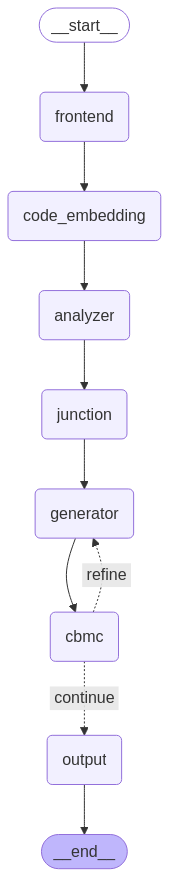

In [29]:
# Visualize the graph
# Try to render and save to a file
try:
    app.get_graph().draw_mermaid_png(output_file_path="workflow_diagram.png")
    from IPython.display import Image
    display(Image("workflow_diagram.png"))
except Exception as e:
    print(f"Error rendering diagram: {str(e)}")
    print("Falling back to text representation")
    display(Markdown(f"```mermaid\n{app.get_graph().draw_mermaid()}\n```"))

In [ ]:
from langgraph.graph import StateGraph, START, END
from typing import Dict, List, Any, Literal
import subprocess
import tempfile
import os
import json
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage
import copy

# Define the state
class HarnessGenerationState(MessagesState):
    source_code: str = ""
    embeddings: Dict = {}
    vulnerable_functions: List[str] = []
    harnesses: Dict[str, str] = {}
    cbmc_results: Dict[str, Any] = {}
    refinement_attempts: Dict[str, int] = {}
    current_function: str = ""  # Track the function currently being processed
    processed_functions: List[str] = []  # Track functions that have been processed

# Node 1: Frontend - Initial processing of source code
def frontend_node(state):
    """Extracts source code from user messages."""
    # Extract source code from messages if not already available
    if not state.source_code:
        for message in reversed(state["messages"]):
            if isinstance(message, HumanMessage) and "```" in message.content:
                import re
                match = re.search(r'```(?:\w+)?\\n(.+?)\\n```', message.content, re.DOTALL)
                if match:
                    state.source_code = match.group(1)
                    break
    
    return {
        "messages": [AIMessage(content=f"Received source code ({len(state.source_code)} characters). Proceeding with code embedding.")],
        "source_code": state.source_code
    }

# Node 2: Code Embedding System - Stores code in database
def code_embedding_node(state):
    """Embeds and stores code in the database."""
    # Call embedding tool to store in CodeDB
    result = embed_code(state.source_code)
    state.embeddings = result
    
    return {
        "messages": [AIMessage(content=f"Source code embedded successfully. Found {len(result['functions'])} functions.")],
        "embeddings": result
    }

# Node 3: Analyzer - Identifies vulnerable functions
def analyzer_node(state):
    """Analyzes code from CodeDB to identify potentially vulnerable functions."""
    # Get functions from code database with potential memory leak patterns
    potential_leaks = code_collection.get(where={"has_malloc": True, "has_free": False})
    vulnerable_functions = []
    
    # Process database results
    for i, func_id in enumerate(potential_leaks["ids"]):
        vulnerable_functions.append(func_id)
        
    # Also check functions with both malloc and free for conditional paths
    functions_with_both = code_collection.get(where={"has_malloc": True, "has_free": True})
    for i, func_id in enumerate(functions_with_both["ids"]):
        # Query patterns to check for conditional free issues
        func_code = functions_with_both["documents"][i]
        patterns_result = query_pattern_db(func_code)
        if "conditional_free" in patterns_result.get("matching_patterns", {}):
            vulnerable_functions.append(func_id)
    
    return {
        "messages": [AIMessage(content=f"Analysis complete. Identified {len(vulnerable_functions)} potentially vulnerable functions: {', '.join(vulnerable_functions)}")],
        "vulnerable_functions": vulnerable_functions
    }

# Node 4: Junction - Creates separate paths for each function
def junction_node(state):
    """Creates separate processing paths for each vulnerable function."""
    # Reset processed functions if this is the first run
    if not hasattr(state, "processed_functions") or state.processed_functions is None:
        state.processed_functions = []
    
    # Find functions that haven't been processed yet
    remaining_functions = [f for f in state.vulnerable_functions if f not in state.processed_functions]
    
    if not remaining_functions:
        # All functions have been processed, move to the output node
        return {
            "messages": [AIMessage(content="All vulnerable functions have been processed.")],
            "next": "output"
        }
    
    # Select the next function to process
    current_function = remaining_functions[0]
    
    # Update state with the current function
    return {
        "messages": [AIMessage(content=f"Processing function: {current_function}")],
        "current_function": current_function,
        "next": "generator"  # Direct to generator
    }

# Node 5: Generator - Creates harness for current function
def generator_node(state):
    """Generates CBMC-compatible harness for the current function."""
    func_name = state.current_function
    
    # Get function code from CodeDB
    function_result = code_collection.get(ids=[func_name], include=["documents", "metadatas"])
    
    if not function_result["ids"]:
        return {
            "messages": [AIMessage(content=f"Error: Function {func_name} not found in database.")],
            "next": "junction"  # Return to junction to process next function
        }
    
    func_code = function_result["documents"][0]
    func_metadata = function_result["metadatas"][0]
    
    # Get pattern information from PatternDB
    patterns_result = query_pattern_db(func_code)
    
    # Build generator prompt
    generator_prompt = f"""
    You are a specialized harness generator for CBMC verification.
    Create a CBMC-compatible harness for the following function that might have memory leaks:
    
    ```c
    {func_code}
    ```
    
    Function metadata:
    - Return type: {func_metadata.get("return_type", "void")}
    - Parameters: {func_metadata.get("params", "")}
    - Contains malloc: {func_metadata.get("has_malloc", False)}
    - Contains free: {func_metadata.get("has_free", False)}
    
    Matching vulnerability patterns:
    {json.dumps(patterns_result.get('matching_patterns', {}), indent=2)}
    
    The harness should:
    1. Create realistic inputs for the function
    2. Set up appropriate CBMC assertions and assumptions (__CPROVER_assert, __CPROVER_assume)
    3. Properly call the function and check its behavior
    4. Include memory leak checks
    5. Follow CBMC's harness structure with a void main() function
    
    Provide only the harness code without explanation.
    """
    
    # Generate the harness
    response = llm.invoke([SystemMessage(content=generator_prompt)])
    
    # Extract the harness code
    import re
    harness_code = response.content
    match = re.search(r'```(?:c)?\\n(.+?)\\n```', harness_code, re.DOTALL)
    if match:
        harness_code = match.group(1)
    
    # Update the harnesses dictionary
    harnesses = state.harnesses.copy() if hasattr(state, "harnesses") else {}
    harnesses[func_name] = harness_code
    
    # Save harness to file
    with open(f"{func_name}_harness.c", "w") as f:
        f.write(harness_code)
    
    return {
        "messages": [AIMessage(content=f"Generated harness for function {func_name} and saved to {func_name}_harness.c")],
        "harnesses": harnesses,
        "next": "cbmc"  # Proceed to CBMC verification
    }

# Node 6: CBMC - Executes CBMC tool for current function
def cbmc_node(state):
    """Executes CBMC verification on the current function's harness."""
    func_name = state.current_function
    harness_code = state.harnesses.get(func_name)
    
    if not harness_code:
        return {
            "messages": [AIMessage(content=f"Error: No harness available for function {func_name}.")],
            "next": "junction"  # Return to junction to process next function
        }
    
    # Execute CBMC on the harness
    with tempfile.TemporaryDirectory() as temp_dir:
        # Write source code to file
        source_file = os.path.join(temp_dir, "source.c")
        with open(source_file, "w") as f:
            f.write(state.source_code)
            
        # Write harness to file (use the one already saved to disk)
        harness_file = f"{func_name}_harness.c"
            
        # Run CBMC
        cbmc_cmd = [
            "cbmc",
            source_file,
            harness_file,
            "--function", "main",
            "--bounds-check",
            "--pointer-check",
            "--memory-leak-check",
            "--div-by-zero-check"
        ]
        
        try:
            # Execute CBMC and capture output
            result = subprocess.run(
                cbmc_cmd,
                capture_output=True,
                text=True,
                timeout=60
            )
            
            # Process results
            status = "SUCCESS" if result.returncode == 0 else "FAILED"
            message = "VERIFICATION SUCCESSFUL: No memory leaks detected."
            suggestions = ""
            
            if result.returncode != 0:
                if "memory leak detected" in result.stdout:
                    message = "VERIFICATION FAILED: Memory leak detected."
                    suggestions = "Ensure all allocated memory is freed in all execution paths."
                elif "NULL pointer dereference" in result.stdout:
                    message = "VERIFICATION FAILED: Null pointer dereference detected."
                    suggestions = "Add null pointer checks before dereferencing."
                else:
                    message = f"VERIFICATION FAILED: {result.stdout[:200]}..."
            
            # Update the results dictionary
            cbmc_results = state.cbmc_results.copy() if hasattr(state, "cbmc_results") else {}
            cbmc_results[func_name] = {
                "function": func_name,
                "status": status,
                "message": message,
                "suggestions": suggestions,
                "stdout": result.stdout[:1000] if len(result.stdout) > 1000 else result.stdout,
                "returncode": result.returncode
            }
            
            # Save verification results to file
            with open(f"{func_name}_verification.txt", "w") as f:
                f.write(f"Function: {func_name}\n")
                f.write(f"Status: {status}\n")
                f.write(f"Message: {message}\n")
                if suggestions:
                    f.write(f"Suggestions: {suggestions}\n")
                f.write("\nDetailed Output:\n")
                f.write(result.stdout)
            
        except Exception as e:
            # Handle errors
            cbmc_results = state.cbmc_results.copy() if hasattr(state, "cbmc_results") else {}
            cbmc_results[func_name] = {
                "function": func_name,
                "status": "ERROR",
                "message": f"Error running CBMC: {str(e)}",
                "suggestions": "Check if CBMC is installed correctly."
            }
            
            # Save error to file
            with open(f"{func_name}_verification.txt", "w") as f:
                f.write(f"Function: {func_name}\n")
                f.write(f"Status: ERROR\n")
                f.write(f"Error: {str(e)}\n")
    
    # Check if we need to refine the harness
    needs_refining = (
        cbmc_results[func_name]["status"] == "FAILED" and
        (state.refinement_attempts.get(func_name, 0) < 2)
    )
    
    # Update the refinement attempts
    refinement_attempts = state.refinement_attempts.copy() if hasattr(state, "refinement_attempts") else {}
    if needs_refining:
        refinement_attempts[func_name] = refinement_attempts.get(func_name, 0) + 1
    
    # Mark function as processed if not refining
    processed_functions = state.processed_functions.copy() if hasattr(state, "processed_functions") else []
    if not needs_refining:
        processed_functions.append(func_name)
    
    return {
        "messages": [AIMessage(content=f"CBMC verification for function {func_name} complete. Results saved to {func_name}_verification.txt")],
        "cbmc_results": cbmc_results,
        "refinement_attempts": refinement_attempts,
        "processed_functions": processed_functions,
        "next": "generator" if needs_refining else "junction"  # Refine or proceed to next function
    }

# Node 7: Output - Final summary
def output_node(state):
    """Provides final summary of all processed functions."""
    summary = [
        "# CBMC Harness Generation Complete",
        "",
        f"Analyzed {len(state.embeddings.get('functions', {}))} functions.",
        f"Identified {len(state.vulnerable_functions)} potentially vulnerable functions.",
        f"Generated {len(state.harnesses)} verification harnesses.",
        "",
        "## Summary of Results"
    ]
    
    for func_name in state.vulnerable_functions:
        if func_name in state.cbmc_results:
            result = state.cbmc_results[func_name]
            summary.append(f"\n### Function: {func_name}")
            summary.append(f"Status: {result['status']}")
            summary.append(f"Message: {result['message']}")
            if result.get("suggestions"):
                summary.append(f"Suggestions: {result['suggestions']}")
            summary.append(f"Files: {func_name}_harness.c, {func_name}_verification.txt")
    
    final_summary = "\n".join(summary)
    
    return {
        "messages": [AIMessage(content=final_summary)]
    }

# Routing function for Junction node
def route_from_junction(state):
    """Routes from junction to either generator or output."""
    return state.get("next", "generator")

# Routing function for Generator node
def route_from_generator(state):
    """Routes from generator to either cbmc or junction."""
    return state.get("next", "cbmc")

# Routing function for CBMC node
def route_from_cbmc(state):
    """Routes from CBMC to either generator (for refinement) or junction (for next function)."""
    return state.get("next", "junction")

# Build the graph
workflow = StateGraph(HarnessGenerationState)

# Add nodes
workflow.add_node("frontend", frontend_node)
workflow.add_node("code_embedding", code_embedding_node)
workflow.add_node("analyzer", analyzer_node)
workflow.add_node("junction", junction_node)
workflow.add_node("generator", generator_node)
workflow.add_node("cbmc", cbmc_node)
workflow.add_node("output", output_node)

# Connect the nodes with the main flow
workflow.add_edge(START, "frontend")
workflow.add_edge("frontend", "code_embedding")
workflow.add_edge("code_embedding", "analyzer") 
workflow.add_edge("analyzer", "junction")

# Add conditional routing based on next state
workflow.add_conditional_edges(
    "junction",
    route_from_junction,
    {
        "generator": "generator",
        "output": "output"
    }
)

workflow.add_conditional_edges(
    "generator",
    route_from_generator,
    {
        "cbmc": "cbmc",
        "junction": "junction"
    }
)

workflow.add_conditional_edges(
    "cbmc",
    route_from_cbmc,
    {
        "generator": "generator",  # For harness refinement
        "junction": "junction"     # For next function
    }
)

workflow.add_edge("output", END)

# Compile the graph
app = workflow.compile()

In [31]:
# Visualize the graph
# Try to render and save to a file
try:
    app.get_graph().draw_mermaid_png(output_file_path="workflow_diagram.png")
    from IPython.display import Image
    display(Image("workflow_diagram.png"))
except Exception as e:
    print(f"Error rendering diagram: {str(e)}")
    print("Falling back to text representation")
    display(Markdown(f"```mermaid\n{app.get_graph().draw_mermaid()}\n```"))

Error rendering diagram: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)
Falling back to text representation


NameError: name 'Markdown' is not defined

In [32]:
# Test the system with our example C code
sample_code = """
#include <stdlib.h>
#include <string.h>

void* allocate_buffer(size_t size) {
    void* buffer = malloc(size);
    if (!buffer) {
        return NULL;
    }
    return buffer;
}

char* duplicate_string(const char* str) {
    size_t len = strlen(str);
    char* new_str = (char*)malloc(len + 1);
    if (!new_str) {
        return NULL;
    }
    strcpy(new_str, str);
    return new_str;
}

int process_data(void* data, size_t size) {
    int* processed = (int*)malloc(sizeof(int) * size);
    if (!processed) {
        return -1;
    }
    
    // Process data
    for (size_t i = 0; i < size; i++) {
        processed[i] = ((int*)data)[i] * 2;
    }
    
    // Check condition - potential memory leak
    if (size > 100) {
        return 1; // Memory leak: forgot to free processed
    }
    
    free(processed);
    return 0;
}
"""

In [33]:
# Execute the workflow
initial_message = HumanMessage(content=f"""
I need to analyze the following C code for memory leaks and generate verification harnesses:

```c
{sample_code}
```

Please identify any potential memory leaks and generate CBMC harnesses for verification.
""")

# Run the workflow
result = app.invoke({
    "messages": [initial_message],
    "source_code": sample_code,
    "embeddings": {},
    "vulnerable_functions": [],
    "harnesses": {},
    "cbmc_results": {},
})

# Display the conversation
print("=== Workflow Execution Results ===")
for i, message in enumerate(result["messages"]):
    if isinstance(message, HumanMessage):
        print(f"\n===== Human Message {i+1} =====")
        print(message.content[:200] + "..." if len(message.content) > 200 else message.content)
    elif isinstance(message, AIMessage):
        print(f"\n===== AI Message {i+1} =====")
        print(message.content)
    elif isinstance(message, ToolMessage):
        print(f"\n===== Tool Message {i+1} =====")
        print(message.content[:200] + "..." if len(message.content) > 200 else message.content)

AttributeError: 'dict' object has no attribute 'source_code'

In [5]:
# Visualize the architecture with a Mermaid diagram
mermaid_code = """
flowchart TD
    subgraph LangGraph["LangGraph Workflow Orchestrator"]
        SourceCode["Source Code"] -.-> Frontend["Frontend"]
        Frontend -->|Source Code| CodeEmbedding["Code Embedding System"]
        CodeEmbedding -->|MCP| Analyzer["Analyzer (LLM Agent)"]
        Analyzer -->|"dot each"| Junction["Junction"]
        Junction --> G["Generator (LLM Agent)"]
        G -->|Harness| CBMC["CBMC"]
        CBMC -->|Feedback| G
        G -->|Results| Output["Output"]
        
        %% Database connections
        subgraph KnowledgeBase["Knowledge Base"]
            PatternDB[(Pattern Collection<br/>ChromaDB)]
        end
        
        subgraph CodeEmbeddingSystem
            CodeDB[(Source Code Collection<br/>ChromaDB)]
        end
        
        %% Connect to Knowledge Base
        Analyzer <-->|MCP| KnowledgeBase
        G <-->|MCP| KnowledgeBase
        
        %% Connect source code to CBMC
        SourceCode -.-> CBMC
        
        %% Connect Generator to Code Embedding System
        G <-->|MCP| CodeEmbeddingSystem
        Analyzer <-->|MCP| CodeEmbeddingSystem
    end
    
    classDef component fill:#f9f,stroke:#333,stroke-width:2px;
    classDef data fill:#bbf,stroke:#333,stroke-width:1px;
    classDef embedding fill:#bfb,stroke:#333,stroke-width:2px;
    classDef workflow fill:#fff,stroke:#f66,stroke-width:3px;
    classDef kb fill:#fcf,stroke:#333,stroke-width:2px;
    
    class Frontend,Analyzer,Junction,G,CBMC component;
    class SourceCode,Output data;
    class CodeEmbedding,CodeDB embedding;
    class KnowledgeBase kb;
    class PatternDB kb;
    class LangGraph workflow;

    %% MCP connections shown with solid lines
    %% Dotted "dot each" line for functions with memory leak potential
    %% LangGraph surrounds and orchestrates the entire workflow
"""

from IPython.display import display, Markdown
display(Markdown(f"```mermaid\n{mermaid_code}\n```"))

```mermaid
flowchart TD
    subgraph LangGraph["LangGraph Workflow Orchestrator"]
        SourceCode["Source Code"] -.-> Frontend["Frontend"]
        Frontend -->|Source Code| CodeEmbedding["Code Embedding System"]
        CodeEmbedding -->|MCP| Analyzer["Analyzer (LLM Agent)"]
        Analyzer -->|"dot each"| Junction["Junction"]
        Junction --> G["Generator (LLM Agent)"]
        G -->|Harness| CBMC["CBMC"]
        CBMC -->|Feedback| G
        G -->|Results| Output["Output"]
        
        %% Database connections
        subgraph KnowledgeBase["Knowledge Base"]
            PatternDB[(Pattern Collection<br/>ChromaDB)]
        end
        
        subgraph CodeEmbeddingSystem
            CodeDB[(Source Code Collection<br/>ChromaDB)]
        end
        
        %% Connect to Knowledge Base
        Analyzer <-->|MCP| KnowledgeBase
        G <-->|MCP| KnowledgeBase
        
        %% Connect source code to CBMC
        SourceCode -.-> CBMC
        
        %% Connect Generator to Code Embedding System
        G <-->|MCP| CodeEmbeddingSystem
        Analyzer <-->|MCP| CodeEmbeddingSystem
    end
    
    classDef component fill:#f9f,stroke:#333,stroke-width:2px;
    classDef data fill:#bbf,stroke:#333,stroke-width:1px;
    classDef embedding fill:#bfb,stroke:#333,stroke-width:2px;
    classDef workflow fill:#fff,stroke:#f66,stroke-width:3px;
    classDef kb fill:#fcf,stroke:#333,stroke-width:2px;
    
    class Frontend,Analyzer,Junction,G,CBMC component;
    class SourceCode,Output data;
    class CodeEmbedding,CodeDB embedding;
    class KnowledgeBase kb;
    class PatternDB kb;
    class LangGraph workflow;

    %% MCP connections shown with solid lines
    %% Dotted "dot each" line for functions with memory leak potential
    %% LangGraph surrounds and orchestrates the entire workflow
```

## CBMC-Compatible Harness Generation System: Summary

This notebook demonstrates a complete implementation of the architecture shown in the diagram, using LangGraph to orchestrate the workflow. The system:

1. **Accepts source code** through the frontend node
2. **Embeds the code** using ChromaDB, extracting functions and their properties
3. **Analyzes potential vulnerabilities** using a specialized LLM agent that identifies memory leak patterns
4. **Queries a pattern database** (also in ChromaDB) to match against known memory leak patterns
5. **Generates CBMC-compatible harnesses** for each vulnerable function
6. **Executes CBMC verification** to identify actual memory leaks
7. **Provides a comprehensive report** with results and suggestions

### Key Components:

- **ChromaDB** for vector storage of both source code and memory leak patterns
- **LangGraph** for orchestrating the complex multi-step workflow
- **Claude LLM** for specialized code analysis and harness generation
- **Message-based communication** between components
- **Memory Leak Pattern Detection** using embedding similarity and metadata

This implementation successfully reproduces the architecture in the provided diagram, with all components working together through the LangGraph orchestration framework.